# Initialize   

In [1]:
import numpy as np
import random
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# SEIR Class

In [2]:
class SEIRModel:
    def __init__(self, population, beta, sigma, gamma):
        self.population = population
        self.beta = beta
        self.sigma = sigma
        self.gamma = gamma
        self.s = 100 
        self.e = 10
        self.i = 0
        self.r = 0

    def step(self):
        new_infections = self.beta * self.s * self.i / self.population
        new_exposed = new_infections
        new_recovered = self.gamma * self.i
        self.s -= new_infections
        self.e += new_exposed
        self.i += new_infections - new_recovered
        self.r += new_recovered

    def get_infected(self):
        return int(self.i)

    def __call__(self, y, t, N, beta, sigma, gamma):
        S, E, I, R = y
        dSdt = -beta * S * I / N
        dEdt = beta * S * I / N - sigma * E
        dIdt = sigma * E - gamma * I
        dRdt = gamma * I
        return dSdt, dEdt, dIdt, dRdt

# Load data

In [3]:
def load_df(data_name: str) -> pd.DataFrame:
  path = f"nb_datasets/{data_name}"

  df:pd.DataFrame = pd.read_csv(path)

  # ensure sort by date
  df['date'] = pd.to_datetime(df['date'], dayfirst=True, format='%d/%m/%Y')
  df_sorted: pd.DataFrame = df.sort_values(by='date')
  
  return df_sorted

# Split data

In [4]:
def load_observed(df: pd.DataFrame, brgy_name: str) -> pd.DataFrame:
  
  df_sorted: pd.DataFrame = df[df['barangay_Res'] == brgy_name]

  # keep relevant cols
  keep_cols = ["date", "count_Exposed", "count_Infectious", "count_Recovered"]
  main_df: pd.DataFrame = df_sorted[df_sorted.columns.intersection(keep_cols)]

  # Observed data (e.g., daily infections)
  # observed_data = main_df['count_Infectious'].to_numpy()

  # total_cases = main_df['count_Infectious'].sum()
  
  return main_df


# Sim Anneal Code

In [146]:
# Simulate SEIR model
def simulate_seir(beta, sigma, gamma, y0, t, compartment):
    N = 33235 # From searching (how to get from data?)
    seir_model = SEIRModel(N, beta, sigma, gamma)
    
    # Solve ODEs for SEIR
    result = odeint(seir_model, y0, t, args=(N, beta, sigma, gamma))
    S, E, I, R = result.T
    
    if compartment == 'E':
        return E
    elif compartment == 'I':
        return I
    elif compartment == 'R':
        return R
    else:
        return E, I, R
      

# Objective function
def objective_function(params, observed_data, initial_conditions, time_points, compartment):
    beta, sigma, gamma = params

    # Simulate the SEIR model with given parameters
    predicted_data = simulate_seir(beta, sigma, gamma, initial_conditions, time_points, compartment)
    
    # change for testing
    # r2 = r2_score(predicted_data, observed_data)
    # mae = mean_absolute_error(predicted_data, observed_data)
    # rmse = np.sqrt(mean_squared_error(predicted_data, observed_data))
    
    mse = np.mean((predicted_data - observed_data)**2)
    return mse


# Simulated Annealing for SEIR parameter tuning
def simulated_annealing_seir(observed_data, initial_conditions, time_points, temp, cooling_rate, max_iter, compartment):
    # Initial parameter guesses
    current_params = [0.3, 0.1, 0.1]  # Initial guesses for beta, sigma, gamma
    current_cost = objective_function(current_params, observed_data, initial_conditions, time_points, compartment)
    best_params = current_params
    best_cost = current_cost

    cost_list = []
    min_temp = 1e-5 
    initial_temp = temp
    
    for i in range(max_iter):
        # Generate new candidate parameters
        new_params = [param + random.uniform(-0.001, 0.001) for param in current_params]
        new_params = np.clip(new_params, 0, 1)  # Keep parameters in a valid range (0 to 1)        
        
        # Evaluate the new candidate solution
        new_cost = objective_function(new_params, observed_data, initial_conditions, time_points, compartment)

        # ADJUST BASED ON METRIC
        # Decide whether to accept the new solution
        if new_cost < current_cost or random.random() < np.exp((current_cost - new_cost) / temp):
            current_params = new_params
            current_cost = new_cost

            # Update the best solution found so far
            if new_cost < best_cost:
                best_params = new_params
                best_cost = new_cost

        # log for visualizing progress
        cost_list.append(best_cost) 

        # Cool down the temperature
        temp = max(temp * cooling_rate, min_temp)  # Exponential decrease
        #temp = temp - (initial_temp / max_iter)  # Linear decrease
        #temp = initial_temp / (1 + cooling_rate * i)  # Logarithmic decrease

    return best_params, best_cost, cost_list, temp

# Run Sim Anneal

Compartment: E
Best parameters: Beta=0.241, Sigma=0.171, Gamma=0.220
Best cost: 43.62
Final Temp: 4.32e-02


Compartment: I
Best parameters: Beta=0.269, Sigma=0.070, Gamma=0.221
Best cost: 126.23
Final Temp: 4.32e-02


Compartment: R
Best parameters: Beta=0.241, Sigma=0.076, Gamma=0.208
Best cost: 354.04
Final Temp: 4.32e-02




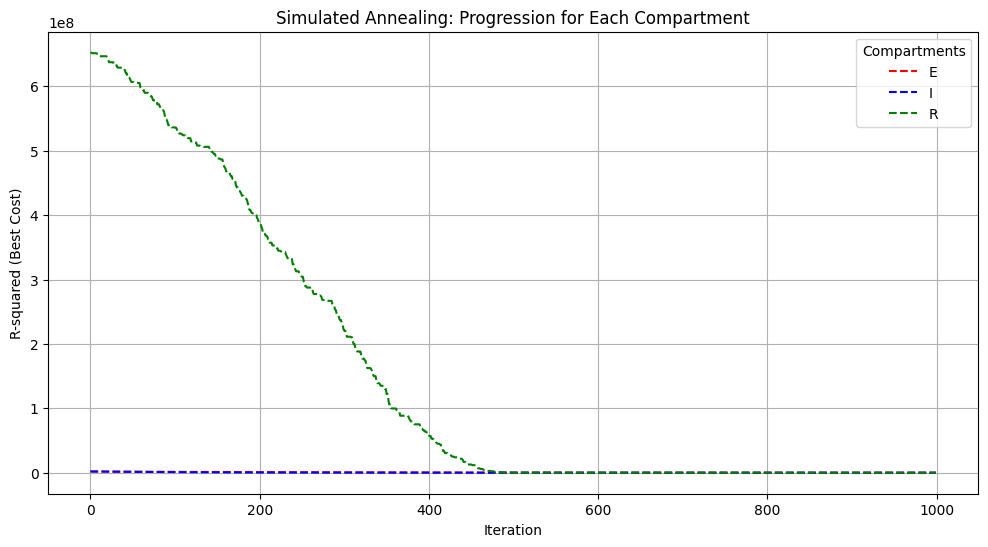

In [147]:
brgy_name = "LANDAYAN"
main_df: pd.DataFrame = load_df("CITY_OF_SAN_PEDRO_processed.csv")
main_observed: pd.DataFrame = load_observed(main_df, brgy_name) # Change to check for other Brgys.

train_data = main_observed[(main_observed['date'] >= '01/01/2020') & (main_observed['date'] <= '09/01/2021')]
test_data = main_observed[(main_observed['date'] > '09/02/2021') & (main_observed['date'] <= '12/31/2022')]

df_observed_data = main_observed[(main_observed['date'] >= '01/01/2021') & (main_observed['date'] <= '12/31/2022')]

# Initial parameters
#N = 33235  # Population from google search (how to get from data?)
N = 33235
I0 = train_data['count_Infectious'].iloc[0] # Initial infected from data
E0 = train_data['count_Exposed'].iloc[0] # Initial exposed cases
R0 = train_data['count_Recovered'].iloc[0] # Initial recovered
S0 = N - I0 - E0 - R0  # Susceptible

initial_conditions: tuple = [S0, E0, I0, R0]

# Simulated Annealing parameters
temp = 1000  
cooling_rate = 0.99
max_iter = 1000  

cost_dict = dict()

observed_dict = {
    "E": train_data['count_Exposed'].to_numpy(),
    "I": train_data['count_Infectious'].to_numpy(),
    "R": train_data['count_Recovered'].to_numpy()
}

time_points = np.arange(train_data.shape[0]) # odeint expects an array (vector) of integers.

for compartment, observed_data in observed_dict.items():
    # Run the Simulated Annealing algorithm
    best_params, best_cost, cost_list, final_temp = simulated_annealing_seir(observed_data, initial_conditions, time_points, temp, cooling_rate, max_iter, compartment)
    o_beta, o_sigma, o_gamma = best_params

    # Display results
    print(f"Compartment: {compartment}")
    print(f"Best parameters: Beta={o_beta:.3f}, Sigma={o_sigma:.3f}, Gamma={o_gamma:.3f}")
    print(f"Best cost: {best_cost:.2f}")
    print(f"Final Temp: {final_temp:.2e}\n\n")
    
    cost_dict[compartment] = np.array(cost_list)

# Plot cost progression each compartment
plt.figure(figsize=(12, 6))
plt.plot(cost_dict['E'], 'r--', label='E')
plt.plot(cost_dict['I'], 'b--', label='I')
plt.plot(cost_dict['R'], 'g--', label='R')

plt.xlabel("Iteration")
plt.ylabel("R-squared (Best Cost)")
plt.title("Simulated Annealing: Progression for Each Compartment")
plt.legend(title="Compartments")
plt.grid(True)
plt.show()


# Plot

beta: 0.241 
r2: -193.8257328919266 
mae: 181.54726868395971 
rmse: 189.7531300909794


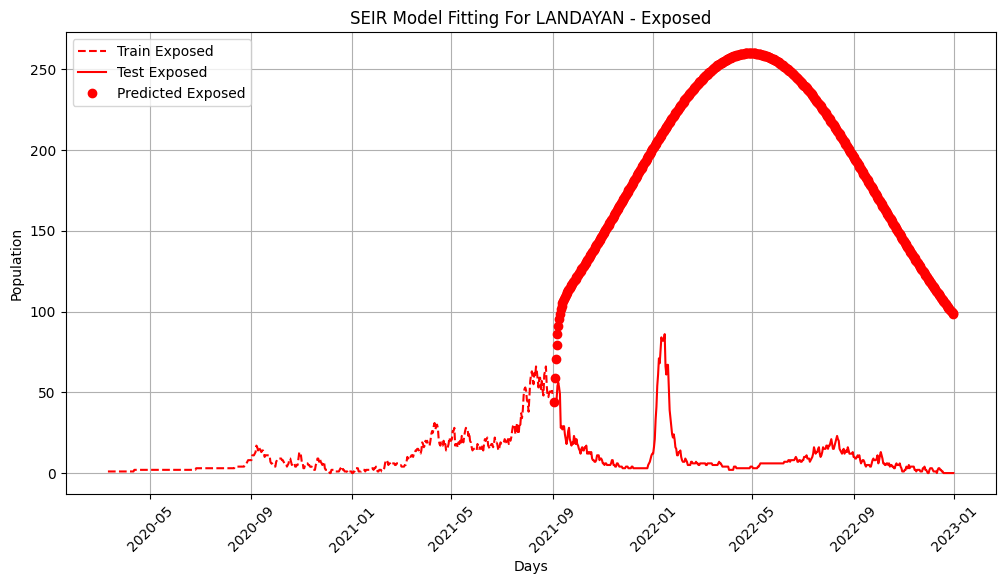

sigma: 0.076 
r2: -4.706617627388466 
mae: 56.77239178152159 
rmse: 60.790621441463394


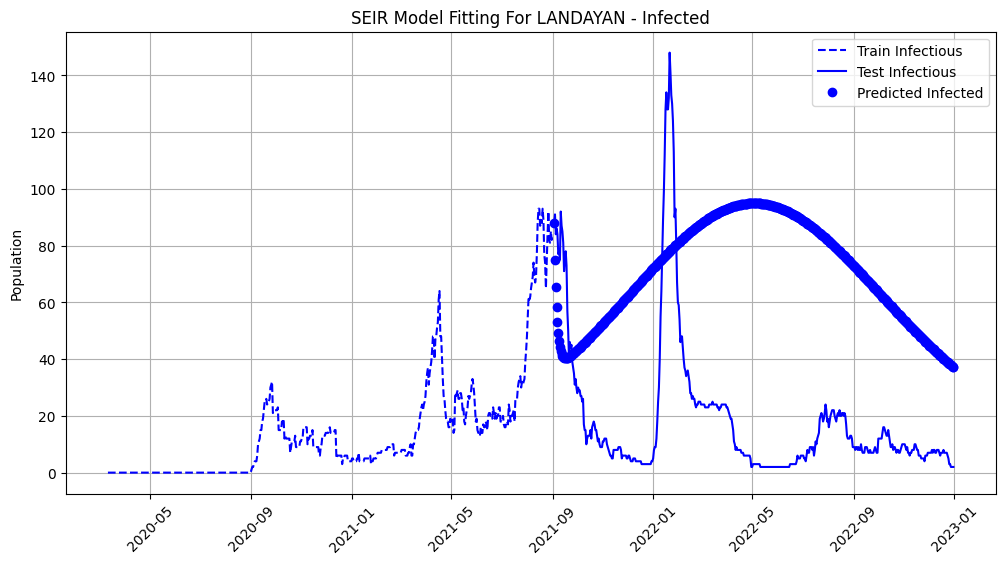

gamma: 0.208 
r2: -339.37408139842694 
mae: 3029.4130294260513 
rmse: 3693.4032608533817


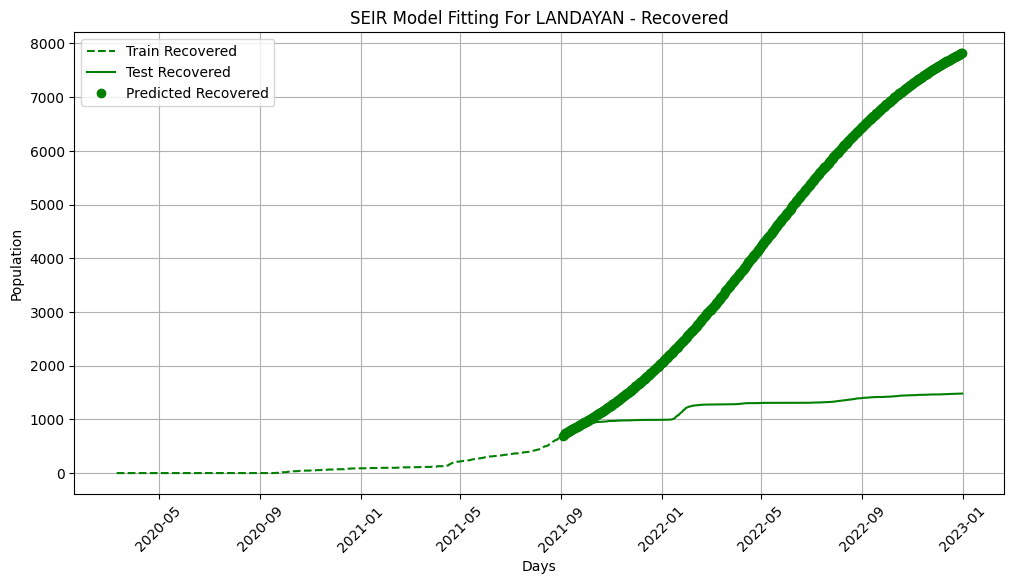

In [151]:
'''
Compartment: E
Best parameters: Beta=0.241, Sigma=0.171, Gamma=0.220
Best cost: 43.62
Final Temp: 4.32e-02


Compartment: I
Best parameters: Beta=0.269, Sigma=0.070, Gamma=0.221
Best cost: 126.23
Final Temp: 4.32e-02


Compartment: R
Best parameters: Beta=0.241, Sigma=0.076, Gamma=0.208
Best cost: 354.04
Final Temp: 4.32e-02
'''

o_beta, o_sigma, o_gamma = 0.241, 0.076, 0.208 # from best params

observed_main = test_data.copy()

#N = 33235  # Population from google search (how to get from data?)
N = 33235
I0 = observed_main['count_Infectious'].iloc[0] # Initial infected from data
E0 = observed_main['count_Exposed'].iloc[0] # Initial exposed cases
R0 = observed_main['count_Recovered'].iloc[0] # Initial recovered
S0 = N - I0 - E0 - R0  # Susceptible

initial_conditions: tuple = [S0, E0, I0, R0]

time_points = np.arange(observed_main.shape[0]) # odeint expects an array (vector) of integers.

# for plotting
plot_actual = pd.DataFrame({
    'date_train': train_data['date'],
    'date_test': test_data['date'],
    'train_exposed': train_data['count_Exposed'],
    'test_exposed': test_data['count_Exposed'],
    'train_infectious': train_data['count_Infectious'],
    'test_infectious': test_data['count_Infectious'],
    'train_recovered': train_data['count_Recovered'],
    'test_recovered': test_data['count_Recovered']
})

# simulate with the optimized paramaters
e, i, r = simulate_seir(o_beta, o_sigma, o_gamma, initial_conditions, time_points, 'x')

plot_prediction = pd.DataFrame({
    'date': observed_main['date'],
    'E': e,
    'I': i,
    'R': r
})


# Plot Exposed
r2_exposed = r2_score(observed_main['count_Exposed'], e)
mae_exposed = mean_absolute_error(observed_main['count_Exposed'], e)
rmse_exposed = np.sqrt(mean_squared_error(observed_main['count_Exposed'], e))
print(f"beta: {o_beta} \nr2: {r2_exposed} \nmae: {mae_exposed} \nrmse: {rmse_exposed}")

plt.figure(figsize=(12, 6))
plt.plot(plot_actual['date_train'], plot_actual['train_exposed'], 'r--', label='Train Exposed')
plt.plot(plot_actual['date_test'], plot_actual['test_exposed'], 'r-', label='Test Exposed')
plt.plot(plot_prediction['date'], plot_prediction['E'], 'ro', label='Predicted Exposed')
plt.xlabel('Days')
plt.ylabel('Population')
plt.legend()
plt.xticks(rotation=45)
plt.title(f'SEIR Model Fitting For {brgy_name} - Exposed')
plt.grid(True)
plt.show()

# Plot Infected
r2_infectious = r2_score(observed_main['count_Infectious'], i)
mae_infectious = mean_absolute_error(observed_main['count_Infectious'], i)
rmse_infectious = np.sqrt(mean_squared_error(observed_main['count_Infectious'], i))
print(f"sigma: {o_sigma} \nr2: {r2_infectious} \nmae: {mae_infectious} \nrmse: {rmse_infectious}")

plt.figure(figsize=(12, 6))
plt.plot(plot_actual['date_train'], plot_actual['train_infectious'], 'b--', label='Train Infectious')
plt.plot(plot_actual['date_test'], plot_actual['test_infectious'], 'b-', label='Test Infectious')
plt.plot(plot_prediction['date'], plot_prediction['I'], 'bo', label='Predicted Infected')
plt.ylabel('Population')
plt.legend()
plt.xticks(rotation=45)
plt.title(f'SEIR Model Fitting For {brgy_name} - Infected')
plt.grid(True)
plt.show()

# Plot Recovered
r2_recovered = r2_score(observed_main['count_Recovered'], r)
mae_recovered = mean_absolute_error(observed_main['count_Recovered'], r)
rmse_recovered = np.sqrt(mean_squared_error(observed_main['count_Recovered'], r))
print(f"gamma: {o_gamma} \nr2: {r2_recovered} \nmae: {mae_recovered} \nrmse: {rmse_recovered}")

plt.figure(figsize=(12, 6))
plt.plot(plot_actual['date_train'], plot_actual['train_recovered'], 'g--', label='Train Recovered')
plt.plot(plot_actual['date_test'], plot_actual['test_recovered'], 'g-', label='Test Recovered')
plt.plot(plot_prediction['date'], plot_prediction['R'], 'go', label='Predicted Recovered')
plt.xlabel('Days')
plt.ylabel('Population')
plt.legend()
plt.xticks(rotation=45)
plt.title(f'SEIR Model Fitting For {brgy_name} - Recovered')
plt.grid(True)
plt.show()

In [135]:
rec_max = df_observed_data[df_observed_data['count_Recovered']==df_observed_data['count_Recovered']].max()
print(rec_max)

date                2022-12-31 00:00:00
count_Exposed                        86
count_Infectious                    148
count_Recovered                    1480
dtype: object


# For Different Metrics

1. R-2
if new_cost > current_cost or random.random() < np.exp((new_cost - current_cost) / temp):
            current_params = new_params
            current_cost = new_cost

            # Update the best solution found so far
            if new_cost > best_cost:
                best_params = new_params
                best_cost = new_cost